Вопросы:
1) Что делать с ссылками \ __Исключим пока вопросы с ссылкаим__

2) Нужно ли чистить вопросы от кода \ __Вопросы с \<pre> \<code> надо отсеить__

3) Что делать с разной длиной \ __Для начала попробовать на всех__

4) Как использовать Tag \ __Взять определенный tag и попробовать с ним__

5) Идея кластеризации для обучения 

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
data_path = "../../data/raw/StackSample/"

In [3]:
pd.set_option("display.max_colwidth", None)

# Прочитаем данные

In [3]:
with open(f"../../data/raw/answers.p", "rb") as f:
    answers = pickle.load(f)

with open(f"../../data/raw/questions.p", "rb") as f:
    questions = pickle.load(f)

with open(f"../../data/raw/tags.p", "rb") as f:
    tags = pickle.load(f)

In [4]:
len(tags)

3750994

In [6]:
questions.rename(
    columns={"Body": "Q_Body", "Score": "Q_Score", "Title": "Q_Title"}, inplace=True
)
answers.rename(
    columns={"Body": "A_Body", "Score": "A_Score", "Id": "A_Id", "ParentId": "Id"},
    inplace=True,
)

In [7]:
questions.head(1)

,Id,OwnerUserId,CreationDate,ParentId,Q_Score,Q_Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Version Control with Subversion</a></p>\r\n\r\n<p>A very good resource for source control in general. Not really TortoiseSVN specific, though.</p>"


In [8]:
answers.head(1)

,A_Id,OwnerUserId,CreationDate,ClosedDate,A_Score,Title,A_Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in one statement,"<p>I've written a database generation script in <a href=""http://en.wikipedia.org/wiki/SQL"">SQL</a> and want to execute it in my <a href=""http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime"">Adobe AIR</a> application:</p>\n\n<pre><code>Create Table tRole (\n roleID integer Primary Key\n ,roleName varchar(40)\n);\nCreate Table tFile (\n fileID integer Primary Key\n ,fileName varchar(50)\n ,fileDescription varchar(500)\n ,thumbnailID integer\n ,fileFormatID integer\n ,categoryID integer\n ,isFavorite boolean\n ,dateAdded date\n ,globalAccessCount integer\n ,lastAccessTime date\n ,downloadComplete boolean\n ,isNew boolean\n ,isSpotlight boolean\n ,duration varchar(30)\n);\nCreate Table tCategory (\n categoryID integer Primary Key\n ,categoryName varchar(50)\n ,parent_categoryID integer\n);\n...\n</code></pre>\n\n<p>I execute this in Adobe AIR using the following methods:</p>\n\n<pre><code>public static function RunSqlFromFile(fileName:String):void {\n var file:File = File.applicationDirectory.resolvePath(fileName);\n var stream:FileStream = new FileStream();\n stream.open(file, FileMode.READ)\n var strSql:String = stream.readUTFBytes(stream.bytesAvailable);\n NonQuery(strSql);\n}\n\npublic static function NonQuery(strSQL:String):void\n{\n var sqlConnection:SQLConnection = new SQLConnection();\n sqlConnection.open(File.applicationStorageDirectory.resolvePath(DBPATH);\n var sqlStatement:SQLStatement = new SQLStatement();\n sqlStatement.text = strSQL;\n sqlStatement.sqlConnection = sqlConnection;\n try\n {\n sqlStatement.execute();\n }\n catch (error:SQLError)\n {\n Alert.show(error.toString());\n }\n}\n</code></pre>\n\n<p>No errors are generated, however only <code>tRole</code> exists. It seems that it only looks at the first query (up to the semicolon- if I remove it, the query fails). Is there a way to call multiple queries in one statement?</p>\n"


# TODO
1) Проверить количество questions имеющих несколько answers // __Одному вопросу может соответствовать более одного ответа__

2) Понять как отбирать ответы // __Попрообовать отбирать вопросы и ответы, у которых score больше 5__

3) Отчистить Body questions и answers от html разметки

### 1. Точно ли на каждый вопрос имеется один ответ или их больше?
Нужно сопоставить __Id__ из answers и __Id__ из questions

In [5]:
answers["Id"].value_counts(sort=False)

92          1
124         1
199         1
269         1
307         1
           ..
40143247    1
40143322    1
40143336    1
40143349    1
40143389    1
Name: Id, Length: 2014516, dtype: int64

Рассмотрим конкретный пример, вопрос с Id = 90

In [16]:
question_90 = questions.loc[questions.Id == 90]

In [17]:
answer_90 = answers.loc[answers.A_Id == 90]

In [18]:
question_90.Q_Body

Series([], Name: Q_Body, dtype: object)

In [19]:
answer_90

,A_Id,OwnerUserId,CreationDate,ClosedDate,A_Score,Title,A_Body
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...


Видим, что вопросы могут содержать ссылки, прочтение содержания которых является ответом на вопрос

1) Код содержится внутри блоков __\<code>__, а картинки __\<img>__

2) Множество __\\n__, которые нужно отчистить // __точно ли нужно?__

3) Попробовать отчистить, оставив вопросы с ссылками без изменений, посмотреть на объём получившейся выборки

### 2. Объядинить таблицы, отчистить от тегов code, img, и имеющие score

In [20]:
print(*answers.columns, sep=", ")
print(*questions.columns, sep=", ")

A_Id, OwnerUserId, CreationDate, ClosedDate, A_Score, Title, A_Body
Id, OwnerUserId, CreationDate, ParentId, Q_Score, Q_Body


Мерджим таблицы

In [21]:
q_a_df = pd.merge(
    questions[["Id", "Q_Score", "Q_Title", "Q_Body"]],
    answers[["Id", "A_Score", "A_Body"]],
    on="Id",
    how="left",
)
q_a_df = pd.merge(
    q_a_df,
    tags[["Id", "Tag"]],
    on="Id",
    how="left",
)

KeyError: "['Q_Title'] not in index"

In [16]:
q_a_df.head()

,Id,Q_Score,Q_Title,Q_Body,A_Score,A_Body,Tag
0,80,26,SQLStatement.execute() - multiple queries in one statement,"<p>I've written a database generation script in <a href=""http://en.wikipedia.org/wiki/SQL"">SQL</a> and want to execute it in my <a href=""http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime"">Adobe AIR</a> application:</p>\n\n<pre><code>Create Table tRole (\n roleID integer Primary Key\n ,roleName varchar(40)\n);\nCreate Table tFile (\n fileID integer Primary Key\n ,fileName varchar(50)\n ,fileDescription varchar(500)\n ,thumbnailID integer\n ,fileFormatID integer\n ,categoryID integer\n ,isFavorite boolean\n ,dateAdded date\n ,globalAccessCount integer\n ,lastAccessTime date\n ,downloadComplete boolean\n ,isNew boolean\n ,isSpotlight boolean\n ,duration varchar(30)\n);\nCreate Table tCategory (\n categoryID integer Primary Key\n ,categoryName varchar(50)\n ,parent_categoryID integer\n);\n...\n</code></pre>\n\n<p>I execute this in Adobe AIR using the following methods:</p>\n\n<pre><code>public static function RunSqlFromFile(fileName:String):void {\n var file:File = File.applicationDirectory.resolvePath(fileName);\n var stream:FileStream = new FileStream();\n stream.open(file, FileMode.READ)\n var strSql:String = stream.readUTFBytes(stream.bytesAvailable);\n NonQuery(strSql);\n}\n\npublic static function NonQuery(strSQL:String):void\n{\n var sqlConnection:SQLConnection = new SQLConnection();\n sqlConnection.open(File.applicationStorageDirectory.resolvePath(DBPATH);\n var sqlStatement:SQLStatement = new SQLStatement();\n sqlStatement.text = strSQL;\n sqlStatement.sqlConnection = sqlConnection;\n try\n {\n sqlStatement.execute();\n }\n catch (error:SQLError)\n {\n Alert.show(error.toString());\n }\n}\n</code></pre>\n\n<p>No errors are generated, however only <code>tRole</code> exists. It seems that it only looks at the first query (up to the semicolon- if I remove it, the query fails). Is there a way to call multiple queries in one statement?</p>\n",12.0,"<p>I wound up using this. It is a kind of a hack, but it actually works pretty well. The only thing is you have to be very careful with your semicolons. : D</p>\n\n<pre><code>var strSql:String = stream.readUTFBytes(stream.bytesAvailable); \nvar i:Number = 0;\nvar strSqlSplit:Array = strSql.split("";"");\nfor (i = 0; i &lt; strSqlSplit.length; i++){\n NonQuery(strSqlSplit[i].toString());\n}\n</code></pre>\n",flex
1,80,26,SQLStatement.execute() - multiple queries in one statement,"<p>I've written a database generation script in <a href=""http://en.wikipedia.org/wiki/SQL"">SQL</a> and want to execute it in my <a href=""http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime"">Adobe AIR</a> application:</p>\n\n<pre><code>Create Table tRole (\n roleID integer Primary Key\n ,roleName varchar(40)\n);\nCreate Table tFile (\n fileID integer Primary Key\n ,fileName varchar(50)\n ,fileDescription varchar(500)\n ,thumbnailID integer\n ,fileFormatID integer\n ,categoryID integer\n ,isFavorite boolean\n ,dateAdded date\n ,globalAccessCount integer\n ,lastAccessTime date\n ,downloadComplete boolean\n ,isNew boolean\n ,isSpotlight boolean\n ,duration varchar(30)\n);\nCreate Table tCategory (\n categoryID integer Primary Key\n ,categoryName varchar(50)\n ,parent_categoryID integer\n);\n...\n</code></pre>\n\n<p>I execute this in Adobe AIR using the following methods:</p>\n\n<pre><code>public static function RunSqlFromFile(fileName:String):void {\n var file:File = File.applicationDirectory.resolvePath(fileName);\n var stream:FileStream = new FileStream();\n stream.open(file, FileMode.READ)\n var strSql:String = stream.readUTFBytes(stream.bytesAvailable);\n NonQuery(strSql);\n}\n\npublic static function NonQuery(strSQL:String):void\n{\n var sqlConnection:SQLConnection = new SQLConnection();\n sqlConnection.open(File.applicationStorageDirectory.resolvePath(DBPATH);\n var sqlStatement:SQLStatement = new SQLStatement();\n sqlStatement.text = strSQL;\n sqlStatement.sqlConnection = sqlConn

In [17]:
len(q_a_df)

6391215

Отбираем нужный score для вопроса и ответов

In [18]:
questions_score = 1
answers_score = 1
q_a_df.query(
    f"Q_Score >= {questions_score} and A_Score >= {answers_score}", inplace=True
)

In [19]:
len(q_a_df)

2349964

### 3. Очистим от HTML разметки и посмотрим распределение длин

Отберем ответы и вопросы, где нет тегов _\<code>_ и _\<img>_

In [27]:
print(*q_a_df.columns, sep=", ")

Id, Q_Score, Q_Title, Q_Body, A_Score, A_Body, Tag


In [20]:
# q_a_df = q_a_df[~q_a_df["A_Body"].str.contains("code")]
# q_a_df = q_a_df[~q_a_df["Q_Body"].str.contains("code")]

q_a_df = q_a_df[~q_a_df["A_Body"].str.contains("img")]
q_a_df = q_a_df[~q_a_df["Q_Body"].str.contains("img")]

q_a_df = q_a_df[~q_a_df["A_Body"].str.contains("a href=")]
q_a_df = q_a_df[~q_a_df["Q_Body"].str.contains("a href=")]

In [27]:
len(q_a_df)

1123493

Преобразуем Title, Q_Body и A_Body в текст

In [22]:
q_a_df["Q_Body"] = q_a_df["Q_Body"].apply(lambda x: BeautifulSoup(x).get_text())
q_a_df["Q_Title"] = q_a_df["Q_Title"].apply(lambda x: BeautifulSoup(x).get_text())
q_a_df["A_Body"] = q_a_df["A_Body"].apply(lambda x: BeautifulSoup(x).get_text())

C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Посмотрим на рапсределение длин вопросов и ответов

In [28]:
q_a_df["Q_BodyLen"] = q_a_df["Q_Body"].apply(lambda x: len(x))
q_a_df["A_BodyLen"] = q_a_df["A_Body"].apply(lambda x: len(x))

Максимальная длина вопроса 34396
Средняя длина вопроса 1050.3831105311738


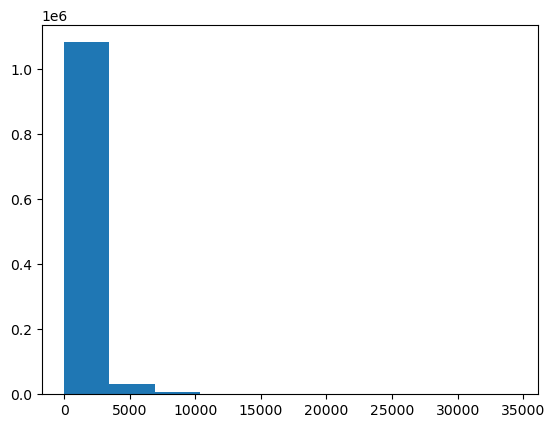

In [29]:
plt.hist(q_a_df["Q_BodyLen"])
print("Максимальная длина вопроса " + str(q_a_df["Q_BodyLen"].max()))
print("Средняя длина вопроса " + str(q_a_df["Q_BodyLen"].mean()))

Максимальная длина ответа 28648
Средняя длина ответа 635.47678000664


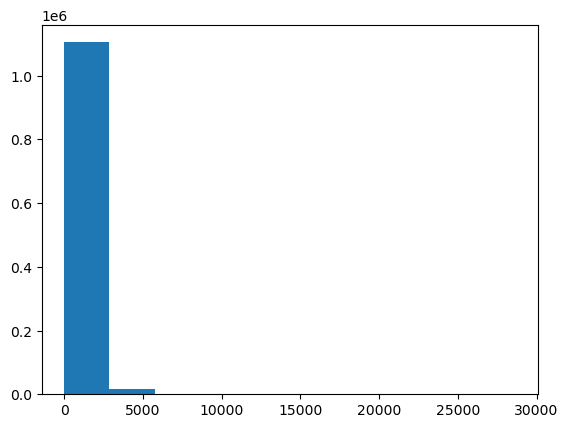

In [30]:
plt.hist(q_a_df["A_BodyLen"])
print("Максимальная длина ответа " + str(q_a_df["A_BodyLen"].max()))
print("Средняя длина ответа " + str(q_a_df["A_BodyLen"].mean()))

In [31]:
q_a_df.head(2)

,Id,Q_Score,Q_Title,Q_Body,A_Score,A_Body,Tag,Q_BodyLen,A_BodyLen
21,120,21,ASP.NET Site Maps,"Has anyone got experience creating SQL-based ASP.NET site-map providers?\nI've got the default XML file web.sitemap working properly with my Menu and SiteMapPath controls, but I'll need a way for the users of my site to create and modify pages dynamically.\nI need to tie page viewing permissions into the standard ASP.NET membership system as well.\n",9.0,"The Jeff Prosise version from MSDN magazine works pretty well, but it has a few flaws:\nAddNode freaks out with links to external sites on your menu (www.google.com, etc.)\nHere's my fix in BuildSiteMap():\nSiteMapNode node = GetSiteMapNodeFromReader(reader);\nstring url = node.Url;\nif (url.Contains("":""))\n{\n string garbage = Guid.NewGuid().ToString(); // SiteMapNode needs unique URLs\n node.Url = ""~/dummy_"" + garbage + "".aspx"";\n AddNode(node, _root);\n node.Url = url;\n}\nelse\n{\n AddNode(node, _root);\n}\n\nSQLDependency caching is cool, but if you don't want to make a trip to the DB everytime your menu loads (to check to see if the dependency has changed) and your menus don't change very often, then why not use HttpRuntime.Cache instead?\npublic override SiteMapNode RootNode\n{\n get\n {\n SiteMapNode temp = (SiteMapNode)HttpRuntime.Cache[""SomeKeyName""];\n if (temp == null)\n {\n temp = BuildSiteMap();\n HttpRuntime.Cache.Insert(""SomeKeyName"", temp, null, DateTime.Now.AddHours(1), Cache.NoSlidingExpiration);\n }\n return temp;\n }\n}\n\n",sql,348,1110
22,120,21,ASP.NET Site Maps,"Has anyone got experience creating SQL-based ASP.NET site-map providers?\nI've got the default XML file web.sitemap working properly with my Menu and SiteMapPath controls, but I'll need a way for the users of my site to create and modify pages dynamically.\nI need to tie page viewing permissions into the standard ASP.NET membership system as well.\n",9.0,"The Jeff Prosise version from MSDN magazine works pretty well, but it has a few flaws:\nAddNode freaks out with links to external sites on your menu (www.google.com, etc.)\nHere's my fix in BuildSiteMap():\nSiteMapNode node = GetSiteMapNodeFromReader(reader);\nstring url = node.Url;\nif (url.Contains("":""))\n{\n string garbage = Guid.NewGuid().ToString(); // SiteMapNode needs unique URLs\n node.Url = ""~/dummy_"" + garbage + "".aspx"";\n AddNode(node, _root);\n node.Url = url;\n}\nelse\n{\n AddNode(node, _root);\n}\n\nSQLDependency caching is cool, but if you don't want to make a trip to the DB everytime your menu loads (to check to see if the dependency has changed) and your menus don't change very often, then why not use HttpRuntime.Cache instead?\npublic override SiteMapNode RootNode\n{\n get\n {\n SiteMapNode temp = (SiteMapNode)HttpRuntime.Cache[""SomeKeyName""];\n if (temp == null)\n {\n temp = BuildSiteMap();\n HttpRuntime.Cache.Insert(""SomeKeyName"", temp, null, DateTime.Now.AddHours(1), Cache.NoSlidingExpiration);\n }\n return temp;\n }\n}\n\n",asp.net,348,1110


### Разделить полученные результаты на тренировочную, валидационную и тестовую выборки.

In [35]:
ready_df = q_a_df.copy()
ready_df.drop(columns=["Q_BodyLen", "A_BodyLen"], inplace=True)

In [36]:
len(ready_df)

223759

In [37]:
train, validate, test = np.split(
    ready_df.sample(frac=1, random_state=42),
    [int(0.65 * len(ready_df)), int(0.8 * len(ready_df))],
)

In [1]:
train.to_csv("../../data/train.csv", sep="\t", index=False)
validate.to_csv("../../data/val.csv", sep="\t", index=False)
test.to_csv("../../data/test.csv", sep="\t", index=False)

NameError: name 'train' is not defined